  # Exploring Statistical Methods on **PRE-CLEANED** bigram frequencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
# from scipy.stats import zscore
# from scipy.spatial.distance import (
# cosine,
# # jensenshannon as jenshan,
# # minkowski as mkow
# )

import numpy as np
from math import sqrt
from sklearn import cluster, decomposition as decomp
_LSC_DATA_DIR = Path("/share/compling/projects/sanpi/source/LSC/data")

In [2]:
orig_frq = None

In [3]:
if orig_frq is not None:
    frq_table = orig_frq
else:
    input_csv = Path(
        '/share/compling/projects/sanpi/results/freq_out/all-frq_thresh877.35f.csv')
    frq_table = pd.read_csv(input_csv)

    if 'adv_lemma' in frq_table.columns:
        frq_table = frq_table.set_index('adv_lemma').transpose()
    if frq_table.index.name != 'adj_lemma':
        if 'adj_lemma' in frq_table.columns:
            frq_table = frq_table.set_index('adj_lemma')
        else:
            frq_table.index.name = 'adj_lemma'
    frq_table = frq_table.apply(pd.to_numeric, downcast='unsigned')
    frq_table.columns.name = 'adv_lemma'
    frq_table.columns = frq_table.columns.astype('string')
    if 'SUM' in frq_table.index:
        SUM_row = frq_table.loc['SUM', :]
    if 'SUM' in frq_table.columns:
        SUM_col = frq_table.loc[:, 'SUM']
    frq_table = frq_table.loc[frq_table.index !=
                              'SUM', frq_table.columns != 'SUM']
    print(frq_table.shape[0], 'rows (adj)')
    print(frq_table.shape[1], 'columns (adv)')
    frq_table.index = frq_table.index.astype('string')
    orig_frq = frq_table.copy()
frq_table

3829 rows (adj)
1021 columns (adv)


adv_lemma,very,more,most,so,not,as,too,really,much,pretty,...,resoundingly,athletically,questionably,inescapably,slyly,second-most,bracingly,deservedly,scandalously,urgently
adj_lemma,,,,,,,,,,,,,,,,,,,,,
good,644398,21021,5880,149256,142461,248773,58563,259683,286470,241515,...,12,4,10,1,4,0,2,5,10,2
many,21205,373,140,1191059,58394,434207,448976,517,214,54,...,0,0,1,0,0,0,0,0,0,0
important,356900,305891,746782,104663,24149,102784,12806,71718,1828,6584,...,0,1,3,5,0,112,0,0,0,120
much,42027,102,22,613054,79899,355270,579790,3063,289,57797,...,0,0,0,0,0,0,0,0,0,0
likely,35628,498300,191813,847,63068,31826,1191,467,526,1312,...,0,0,0,0,0,14,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
directional,93,222,52,8,36,6,12,3,2,6,...,0,0,0,0,0,0,0,0,0,0
anti-democratic,24,21,69,10,23,16,2,4,0,3,...,0,0,0,0,0,0,0,0,0,0
panicked,54,159,31,94,8,28,65,16,3,15,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def heatmap(df, columns=None, save_name=None, size=(8, 10)):

    plt.figure(figsize=size, dpi=120, facecolor="white")

    adv_labels = df.index
    if columns:
        df = df.loc[:, columns]
    df = df.astype('float')
    # Displaying dataframe as an heatmap
    # with diverging colourmap as RdYlBu
    plt.imshow(df, cmap="plasma")
    # plt.imshow(df, cmap="gist_rainbow")
    # plt.imshow(df, cmap="jet")
    # plt.imshow(df, cmap="viridis")
    # plt.autoscale(enable=True, axis='both')
    # Displaying a color bar to understand
    # which color represents which range of data
    plt.colorbar()
    # Assigning labels of x-axis
    # according to dataframe
    plt.xticks(range(len(df.columns)), df.columns, rotation=-30)
    # Assigning labels of y-axis
    # according to dataframe
    plt.yticks(range(len(df.index)), adv_labels)
    # Displaying the figure
    plt.show()

def sample_counts(frq_table, label, 
                  rows=pd.Series(dtype='string'), 
                  columns=pd.Series(dtype='string')):

    s = frq_table.iloc[:int(frq_table.shape[0]/4), :int(frq_table.shape[1]/3)]

    rows = rows if any(rows) else s.sample(16).index
    columns = columns if any(columns) else s.T.sample(8).index
    sample_df = s.loc[rows, columns]
    # print(sample_df.describe().T.round(2).to_markdown())
    # fig = plt.figure(figsize=(6, 8), dpi=300)
    fig = plt.figure(dpi=130)
    # ax.barh(s20x10, width=1)
    sample_df.plot(kind='barh',
                   width=0.8,
                   figsize=(8, 10),
                   position=1,
                   title=f'{label} of sample',
                   grid=True,
                   #  colormap="gist_rainbow",
                   #  colormap="brg",
                   #    colormap="nipy_spectral_r",
                   colormap="Set1",
                   ax=plt.gca())
    plt.show()
    fig = plt.figure(dpi=150)
    sample_df.plot(kind='barh',
                   stacked=True,
                   width=0.8,
                   figsize=(8, 10),
                   position=1,
                   title=f'{label} of sample',
                   grid=True,
                   #  colormap="gist_rainbow",
                   #  colormap="brg",
                   #    colormap="nipy_spectral_r",
                   colormap="Set1",
                   ax=plt.gca()
                   )
    plt.show()
    heatmap(sample_df, size=(8, 10))
    # print(sample_df.round().to_markdown(floatfmt=',.0f'))

    return s, sample_df

  ## Standardization & Normalization
  Don't want to use `zscore` because it will understate real variation for frequency vectors with large ranges, and exaggerate variation for vectors with small ranges.

  Instead, use *mean-standardization* as recommended in Moisl (2015). I.e. divide each vector by its mean. This will yield vector of floats > 0.

  🤚 there may be an issue if the mean value is ever 0, because the mean standardized values will be undefined (`NaN`)

In [5]:
def standardize(df):
    if any(df.mean() == 0):
        print('WARNING: data contains vectors with mean of 0')
    token_info = df.mean().to_frame().rename(columns={0: 'token_mean'})
    print(token_info.assign(total=df.sum()).sort_values(
        'token_mean', ascending=False))
    mdf = df.apply(lambda col: col / (col.mean()))
    # z = s.apply(zscore)
    # m.columns = 'ms_' + m.columns
    # z.columns = 'zs_' + z.columns
    # print('standard deviation of mean-standardized columns')
    cvar = mdf.apply(pd.DataFrame.std).round(3)
    # print('coefficient of variation of raw frequency columns (std/mean)')
    # print([round(s[c].std()/s[c].mean(), 3) for c in s.columns])
    # return m, z, cvar
    return mdf, cvar

sample_lemmas = {
    'adv': frq_table.T.sample(10).sort_index().index.to_list(), 
    'adj': frq_table.sample(20).sort_index().index.to_list()
}

 ### Mean-standardized by **adverb**

In [6]:
Rm_df, Rvar = standardize(frq_table)

               token_mean    total
adv_lemma                         
very          2573.133194  9852527
more          2432.117263  9312577
most          1967.920084  7535166
so            1489.295377  5702512
not           1442.752938  5524301
...                   ...      ...
second-most      0.231131      885
bracingly        0.230870      884
deservedly       0.230086      881
scandalously     0.229303      878
urgently         0.229042      877

[1021 rows x 2 columns]


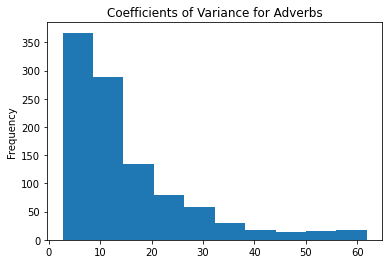

In [7]:
Rvar = Rvar.sort_values(ascending=False)
Rvar.plot(kind='hist')
plt.title('Coefficients of Variance for Adverbs')
plt.show()

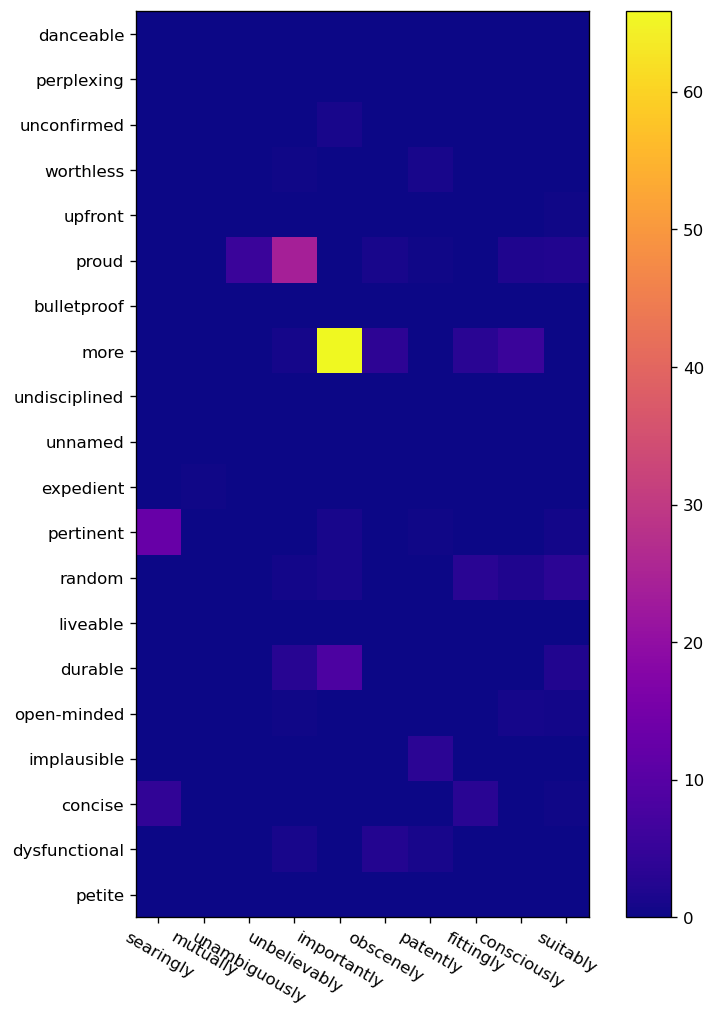

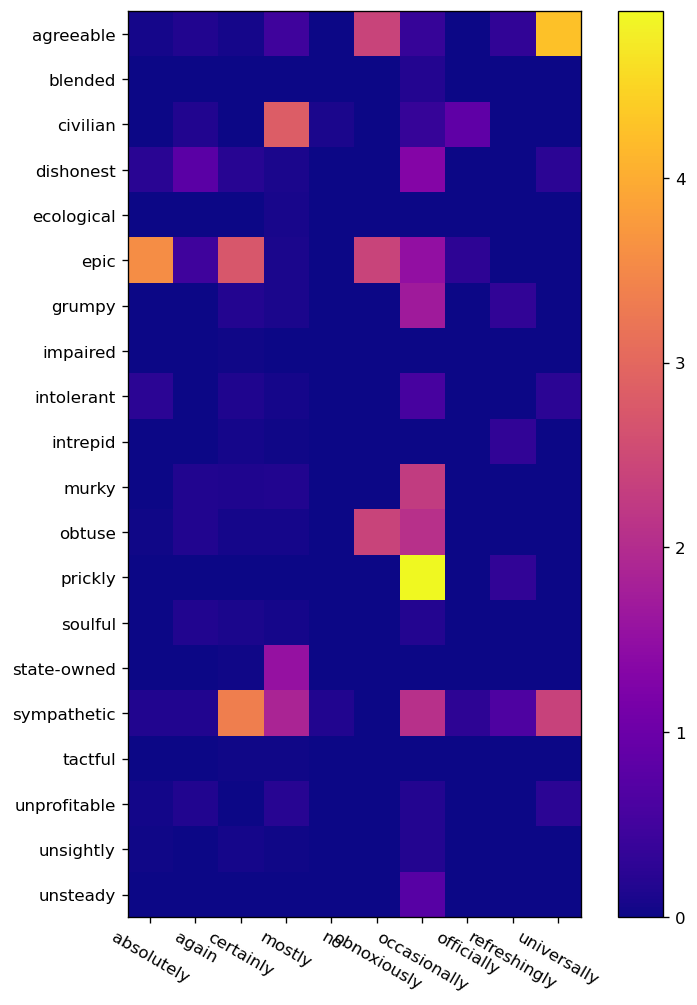

In [8]:
heatmap(Rm_df.sample(20).T.sample(10).T)
heatmap(Rm_df.loc[sample_lemmas['adj'], sample_lemmas['adv']] )

In [9]:
Rvar.nlargest(20)

adv_lemma
chock         61.852
scantily      61.501
crystal       61.324
nerve         61.041
brand         60.914
de            60.864
proof         60.028
upwardly      59.446
squeaky       59.392
middle        59.243
hiv           58.776
golden        58.747
spotlessly    58.275
funnily       57.154
thinly        56.530
vitally       56.241
wide          56.194
terminally    55.928
closely       54.924
at            54.750
dtype: float64

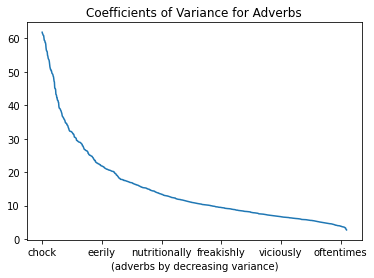

In [10]:
Rvar.plot()
plt.title('Coefficients of Variance for Adverbs')
plt.xlabel('(adverbs by decreasing variance)')
plt.show()

 💾 *Save **Adverb** Mean Standardized Frequency Data*

In [11]:
thresh = int(input_csv.name.split('.')[0].split('_thresh')[1])
limit = min(frq_table.sum())
lim_label = ''
if limit > thresh:
    lim_label = f'_LIMIT{min(frq_table.sum())}'

adv_ms_stem = f"{input_csv.stem}{lim_label}_ADV-mn-std"
print(f'Saving adverb mean standardized frequency data as {adv_ms_stem}.csv')

Saving adverb mean standardized frequency data as all-frq_thresh877.35f_ADV-mn-std.csv


In [12]:
Rm_df.to_csv(input_csv.with_stem(adv_ms_stem))

 ### Mean-standardized by **adjective**

In [13]:
Jm_df, Jvar = standardize(frq_table.T)
Jvar = Jvar.sort_values(ascending=False)

                  token_mean    total
adj_lemma                            
good             2847.058766  2906847
many             2424.337904  2475249
important        2166.793340  2212296
much             1988.283056  2030037
likely           1034.741430  1056471
...                      ...      ...
directional         0.860921      879
anti-democratic     0.860921      879
panicked            0.859941      878
long-winded         0.858962      877
pointy              0.858962      877

[3829 rows x 2 columns]


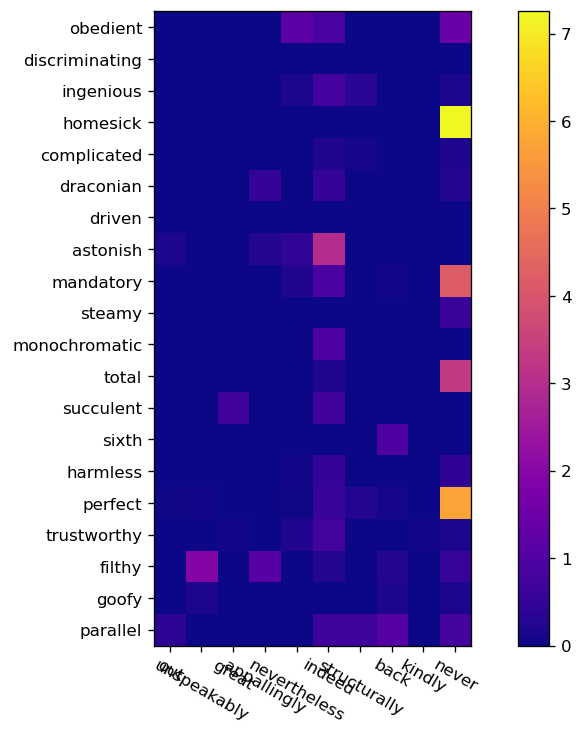

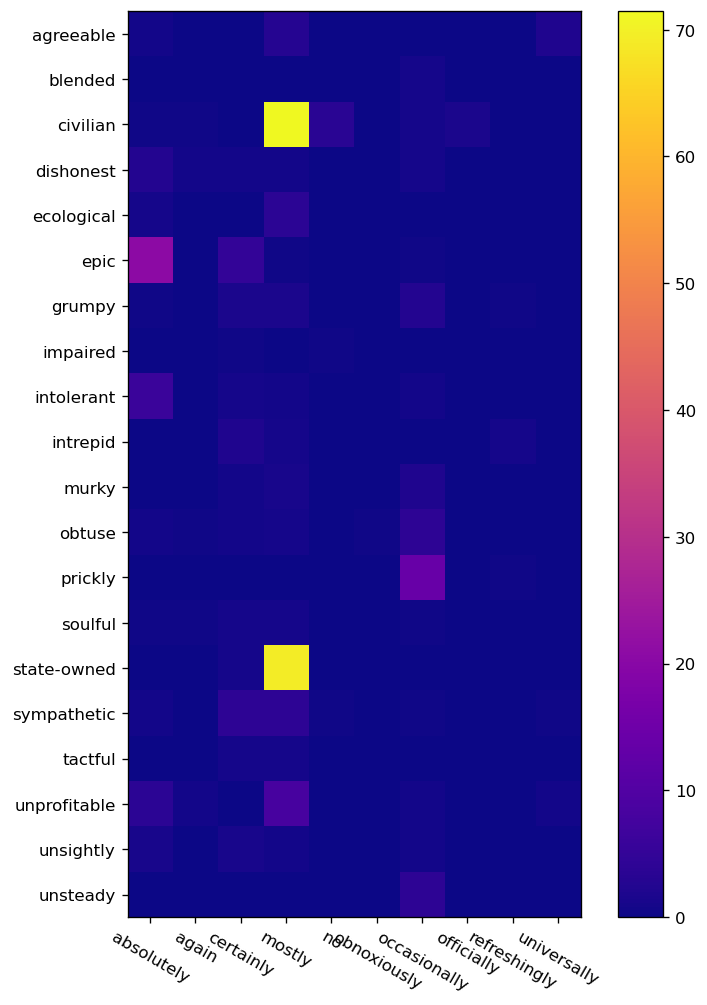

In [14]:
heatmap(Jm_df.sample(10).T.sample(20), size=(10, 7))
heatmap(Jm_df.T.loc[sample_lemmas['adj'], sample_lemmas['adv']] )

In [15]:
Jvar.nlargest(10)

adj_lemma
rigueur           31.953
away              31.731
wanted            31.502
wracking          31.455
marrow            31.354
own               31.343
first             30.318
intentioned       29.971
populous          28.702
inconsiderable    28.459
dtype: float64

In [16]:
Jm_df.round(3)

adj_lemma,good,many,important,much,likely,more,easy,different,difficult,available,...,argumentative,distinguishing,famed,non-partisan,contiguous,directional,anti-democratic,panicked,long-winded,pointy
adv_lemma,,,,,,,,,,,,,,,,,,,,,
very,226.338,8.747,164.713,21.137,34.432,0.068,128.425,259.806,227.911,0.490,...,91.347,33.608,11.602,23.205,4.646,108.024,27.877,62.795,109.434,174.629
more,7.383,0.154,141.172,0.051,481.570,1.610,7.531,13.651,267.664,11.785,...,137.598,45.198,135.747,17.403,123.124,257.863,24.392,184.896,81.494,103.613
most,2.065,0.058,344.648,0.011,185.373,0.089,1.630,1.524,93.149,1.684,...,45.095,890.043,756.468,27.845,9.292,60.400,80.147,36.049,31.433,9.314
so,52.425,491.292,48.303,308.333,0.819,2.909,90.545,43.896,32.252,0.596,...,40.470,1.159,18.564,8.122,6.969,9.292,11.615,109.310,55.881,53.553
not,50.038,24.087,11.145,40.185,60.950,18.063,134.089,5.370,30.985,174.920,...,72.846,0.000,0.000,20.884,249.733,41.816,26.716,9.303,17.463,50.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
second-most,0.000,0.000,0.052,0.000,0.014,0.000,0.000,0.000,0.013,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
bracingly,0.001,0.000,0.000,0.000,0.000,0.000,0.001,0.015,0.002,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
deservedly,0.002,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


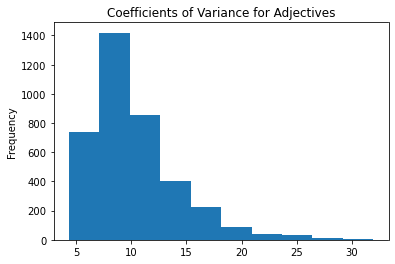

In [17]:
Jvar.plot(kind='hist')
plt.title('Coefficients of Variance for Adjectives')
plt.show()

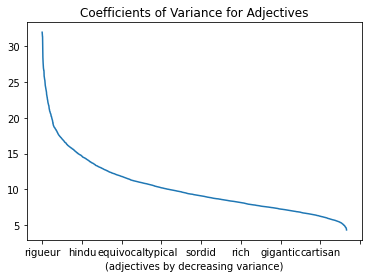

In [18]:
Jvar.plot()
plt.title('Coefficients of Variance for Adjectives')
plt.xlabel('(adjectives by decreasing variance)')
plt.show()

 💾 *Save **Adjective** Mean Standardized Frequency Data*

In [19]:
adj_ms_stem = f"{input_csv.stem}{lim_label}_ADJ-mn-std"
print(
    f'Saving adjective mean standardized frequency data as {adj_ms_stem}.csv')

Saving adjective mean standardized frequency data as all-frq_thresh877.35f_ADJ-mn-std.csv


In [20]:
Jm_df.to_csv(input_csv.with_stem(adj_ms_stem))